<a href="https://colab.research.google.com/github/Fabian-lewis/medical-diagnostic-pricing-audit/blob/main/proposed_risk_multipliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Objectives

Suggest a simple pricing adjustment.


---



Our define BMI segments

    Non-smoker → multiplier = 1.0 (baseline)

    Smoker + BMI < 30 → multiplier ≈ 1.1 (small increase)

    Smoker + BMI ≥ 30 → multiplier ≈ 1.8–2.2 (cost cliff)

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Load the data

from google.colab import files

# upload the data
uploaded = files.upload()

# Get the filename
filename = list(uploaded.keys())[0]

# Read the file
df = pd.read_csv(filename)

# Copy the data
data = df.copy()

data.head()

Saving cleaned_insurance_data.csv to cleaned_insurance_data.csv


,Unnamed: 0,age,sex,bmi,children,smoker,region,charges,smoker_binary,bmi_category,bmi_smoker_interaction
0,0,19,female,27.900,0,yes,southwest,16884.92400,1,Overweight,27.9
1,1,18,male,33.770,1,no,southeast,1725.55230,0,Obese,0.0
2,2,28,male,33.000,3,no,southeast,4449.46200,0,Obese,0.0
3,3,33,male,22.705,0,no,northwest,21984.47061,0,Normal,0.0
4,4,32,male,28.880,0,no,northwest,3866.85520,0,Overweight,0.0


In [6]:
# =========================================================
# INTERACTION MODEL: BMI × Smoking
# =========================================================
# Purpose:
# - Capture compounded risk between BMI and smoking
# - Explain high costs among obese smokers
# - Improve explanatory power over baseline model
# =========================================================

interaction_model = smf.ols(
    formula="""
        charges ~
        age +
        bmi +
        smoker_binary +
        bmi:smoker_binary +
        children +
        region
    """,
    data=data
).fit()


## INTERACTION PLOT: Predicted Charges vs BMI

sns.set(style="whitegrid")

# Create BMI range for predictions
bmi_range = np.linspace(df['bmi'].min(), df['bmi'].max(), 100)

# Build prediction dataframe
pred_df = pd.DataFrame({
    'age': data['age'].median(),           # use median age
    'children': data['children'].median(), # use median children
    'region': 'southeast',               # reference region
    'bmi': np.tile(bmi_range, 2),
    'smoker_binary': [0]*100 + [1]*100   # 0 = Non-Smoker, 1 = Smoker
})

#  Predict charges using the interaction model
pred_df['predicted_charges'] = interaction_model.predict(pred_df)


In [9]:
# Define a function to assign risk multiplier
def assign_multiplier(row):
    if row['smoker_binary'] == 0:  # Non-smoker
        return 1.0
    elif row['smoker_binary'] == 1 and row['bmi'] < 30:  # Smoker, BMI < 30
        return 1.1
    else:  # Smoker, BMI >= 30
        return 2.0  # you can adjust to 1.8 or 2.2 if desired

# Apply to dataframe
pred_df['risk_multiplier'] = pred_df.apply(assign_multiplier, axis=1)

# Preview
pred_df[['smoker_binary','bmi','risk_multiplier']].head(10)


,smoker_binary,bmi,risk_multiplier
0,0,15.960000,1.0
1,0,16.335455,1.0
2,0,16.710909,1.0
3,0,17.086364,1.0
4,0,17.461818,1.0
5,0,17.837273,1.0
6,0,18.212727,1.0
7,0,18.588182,1.0
8,0,18.963636,1.0
9,0,19.339091,1.0


In [10]:
## Simulate new charges

# Use predicted charges from interaction model
pred_df['adjusted_charges'] = pred_df['predicted_charges'] * pred_df['risk_multiplier']

# Preview
pred_df[['bmi','smoker_binary','predicted_charges','risk_multiplier','adjusted_charges']].head(10)


,bmi,smoker_binary,predicted_charges,risk_multiplier,adjusted_charges
0,15.960000,0,7510.718521,1.0,7510.718521
1,16.335455,0,7519.209393,1.0,7519.209393
2,16.710909,0,7527.700265,1.0,7527.700265
3,17.086364,0,7536.191137,1.0,7536.191137
4,17.461818,0,7544.682009,1.0,7544.682009
5,17.837273,0,7553.172881,1.0,7553.172881
6,18.212727,0,7561.663753,1.0,7561.663753
7,18.588182,0,7570.154625,1.0,7570.154625
8,18.963636,0,7578.645497,1.0,7578.645497
9,19.339091,0,7587.136369,1.0,7587.136369


In [12]:
## Summarize by segment

# Define BMI bands
def bmi_band(bmi):
    if bmi < 25:
        return 'Normal/Underweight'
    elif bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

pred_df['BMI_Band'] = pred_df['bmi'].apply(bmi_band)

# Group by Smoker and BMI Band
summary_table = pred_df.groupby(['smoker_binary','BMI_Band'])[['risk_multiplier']].mean().reset_index()

# Map smoker_binary to text for readability
summary_table['Smoker Status'] = summary_table['smoker_binary'].map({0:'Non-Smoker', 1:'Smoker'})

# Reorder columns
summary_table = summary_table[['Smoker Status','BMI_Band','risk_multiplier']]

# Display table
summary_table


,Smoker Status,BMI_Band,risk_multiplier
0,Non-Smoker,Normal/Underweight,1.0
1,Non-Smoker,Obese,1.0
2,Non-Smoker,Overweight,1.0
3,Smoker,Normal/Underweight,1.1
4,Smoker,Obese,2.0
5,Smoker,Overweight,1.1


### Proposed Risk Multipliers

- **Non-smokers:** Multiplier = 1.0 → baseline, no adjustment.  
- **Smokers, BMI < 30:** Multiplier = 1.1 → small adjustment, reflects slightly higher risk.  
- **Smokers, BMI ≥ 30:** Multiplier = 2.0 → significant adjustment, reflects cost cliff observed in data.  

**Business impact:**  
- Ensures high-risk smokers are priced correctly.  
- Prevents overcharging low-risk smokers.  
- Easy to communicate and implement.


/tmp/ipython-input-849840636.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


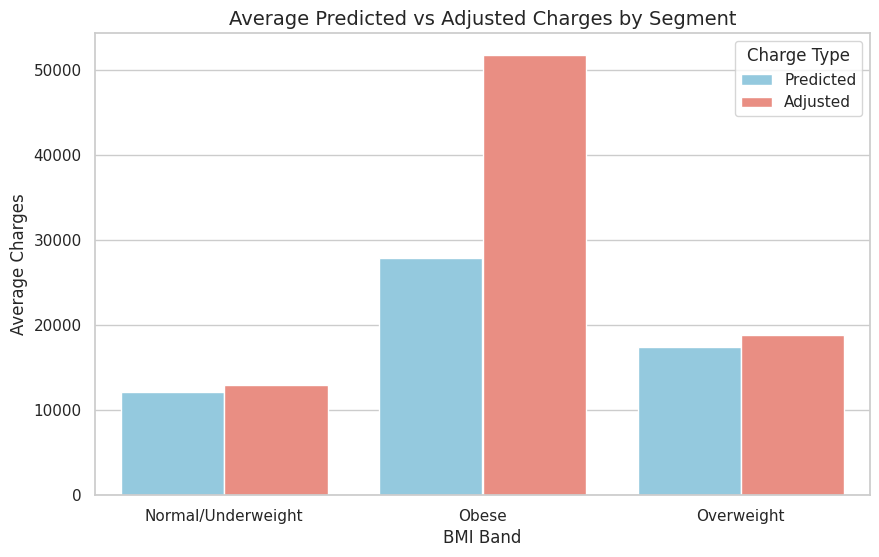

In [13]:
# Group by smoker status and BMI band, calculate averages
segment_summary = pred_df.groupby(['smoker_binary','BMI_Band']).agg(
    avg_predicted = ('predicted_charges','mean'),
    avg_adjusted = ('adjusted_charges','mean')
).reset_index()

# Map smoker_binary to text
segment_summary['Smoker Status'] = segment_summary['smoker_binary'].map({0:'Non-Smoker',1:'Smoker'})

# Reorder columns for plotting
segment_summary = segment_summary[['Smoker Status','BMI_Band','avg_predicted','avg_adjusted']]
segment_summary

# Set up the figure
plt.figure(figsize=(10,6))

# Plot predicted vs adjusted charges using seaborn
sns.barplot(
    data=pd.melt(segment_summary, id_vars=['Smoker Status','BMI_Band'],
                 value_vars=['avg_predicted','avg_adjusted'],
                 var_name='Charge Type', value_name='Amount'),
    x='BMI_Band', y='Amount', hue='Charge Type',
    ci=None, palette=['skyblue','salmon']
)

plt.title("Average Predicted vs Adjusted Charges by Segment", fontsize=14)
plt.xlabel("BMI Band")
plt.ylabel("Average Charges")
plt.legend(title="Charge Type", labels=['Predicted', 'Adjusted'])
plt.show()


In [18]:
# Create a final dataset for Tableau

# Map smoker_binary to text for readability
pred_df['Smoker Status'] = pred_df['smoker_binary'].map({0:'Non-Smoker', 1:'Smoker'})

tableau_df = pred_df[['bmi','Smoker Status','BMI_Band','region','predicted_charges','adjusted_charges','age','children']]


from google.colab import files
tableau_df.to_csv('tableau_df.csv', index=False)
files.download('tableau_df.csv')

#tableau_df.head()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>